<a href="https://colab.research.google.com/github/annagossner/mba_textmining/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sentiment Analysis

# Imports

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# Reading the datasets

In [25]:
df = pd.read_csv('https://raw.githubusercontent.com/annagossner/mba_textmining/main/data/Sentiment.csv')
df.shape

(13871, 21)

# Data cleaning & preparation

In [26]:
# converting all tweets to lowercase text
df['text'] = df['text'].apply(lambda x: x.lower())

df.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,rt @nancyleegrahn: how did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,rt @scottwalker: didn't catch the full #gopdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,rt @tjmshow: no mention of tamir rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,rt @robgeorge: that carly fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,rt @danscavino: #gopdebate w/ @realdonaldtrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [27]:
# removing unnecessary columns from data
df = df[['text', 'sentiment', 'subject_matter']]

In [5]:
df.head(20)

,text,sentiment,subject_matter
0,rt @nancyleegrahn: how did everyone feel about...,Neutral,None of the above
1,rt @scottwalker: didn't catch the full #gopdeb...,Positive,None of the above
2,rt @tjmshow: no mention of tamir rice and the ...,Neutral,None of the above
3,rt @robgeorge: that carly fiorina is trending ...,Positive,None of the above
4,rt @danscavino: #gopdebate w/ @realdonaldtrump...,Positive,None of the above
5,"rt @gregabbott_tx: @tedcruz: ""on my first day ...",Positive,None of the above
6,rt @warriorwoman91: i liked her and was happy ...,Negative,FOX News or Moderators
7,going on #msnbc live with @thomasaroberts arou...,Neutral,None of the above
8,deer in the headlights rt @lizzwinstead: ben c...,Negative,None of the above
9,rt @nancyosborne180: last night's debate prove...,Negative,None of the above


# Data exploration

subject_matter
Abortion                                 293
FOX News or Moderators                  2900
Foreign Policy                           366
Gun Control                               61
Healthcare (including Medicare)           67
Immigration                              211
Jobs and Economy                         251
LGBT issues                              126
None of the above                       8148
Racial issues                            353
Religion                                 407
Women's Issues (not abortion though)     362
Name: text, dtype: int64


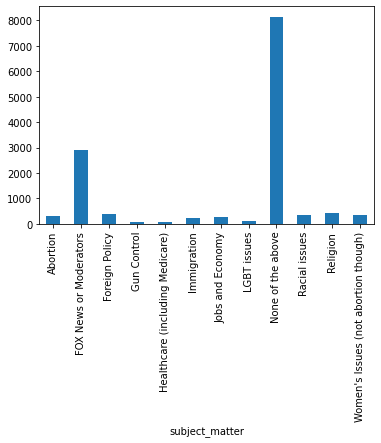

In [28]:
# how many tweets per subject?
print(df.groupby(['subject_matter'])['text'].count())
df.groupby(['subject_matter'])['text'].count().plot(kind="bar")
plt.show()

sentiment
Negative    8493
Neutral     3142
Positive    2236
Name: text, dtype: int64


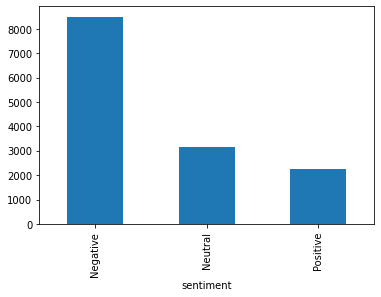

In [7]:
# how many tweets per sentiment category?
print(df.groupby(['sentiment'])['text'].count())
df.groupby(['sentiment'])['text'].count().plot(kind="bar")
plt.show()

In [59]:
# removing neutral sentiment from data
df = df[df.sentiment != "Neutral"]
df.shape

(10729, 3)

In [30]:
# splitting the dataset into train and test set
train, test = train_test_split(df,test_size = 0.1)

# Stopwords

In [32]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 
             'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [33]:
# cleaning & removing stopwords
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df['text'] = df['text'].apply(lambda text: cleaning_stopwords(text))
df['text'].head()

1    rt @scottwalker: didn't catch full #gopdebate ...
3    rt @robgeorge: carly fiorina trending -- hours...
4    rt @danscavino: #gopdebate w/ @realdonaldtrump...
5    rt @gregabbott_tx: @tedcruz: "on first day res...
6    rt @warriorwoman91: liked happy heard going mo...
Name: text, dtype: object

In [34]:
# cleaning & removing punctuation
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
df['text']= df['text'].apply(lambda x: cleaning_punctuations(x))
df['text'].tail()

13866    rt cappyyarbrough love see men never faced pre...
13867    rt georgehenryw thought huckabee exceeded expe...
13868    rt lrihendry tedcruz president always tell tru...
13869    rt jrehling gopdebate donald trump says doesnt...
13870    rt lrihendry tedcruz headed presidential debat...
Name: text, dtype: object

In [35]:
# cleaning & removing repeating characters
import re
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
df['text'] = df['text'].apply(lambda x: cleaning_repeating_char(x))
df['text'].tail()

13866    rt cappyyarbrough love see men never faced pre...
13867    rt georgehenryw thought huckabee exceeded expe...
13868    rt lrihendry tedcruz president always tell tru...
13869    rt jrehling gopdebate donald trump says doesnt...
13870    rt lrihendry tedcruz headed presidential debat...
Name: text, dtype: object

In [36]:
# stemming
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
df['text']= df['text'].apply(lambda x: stemming_on_text(x))
df['text'].head()

1    rt scottwalker didnt catch full gopdebate last...
3    rt robgeorge carly fiorina trending  hours deb...
4    rt danscavino gopdebate w realdonaldtrump deli...
5    rt gregabbotttx tedcruz on first day rescind e...
6    rt warriorwoman1 liked happy heard going moder...
Name: text, dtype: object

In [41]:
# applying lemmatizer
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
df['text'] = df['text'].apply(lambda x: lemmatizer_on_text(x))
df['text'].head()

1    rt scottwalker didnt catch full gopdebate last...
3    rt robgeorge carly fiorina trending  hours deb...
4    rt danscavino gopdebate w realdonaldtrump deli...
5    rt gregabbotttx tedcruz on first day rescind e...
6    rt warriorwoman1 liked happy heard going moder...
Name: text, dtype: object

Positive words


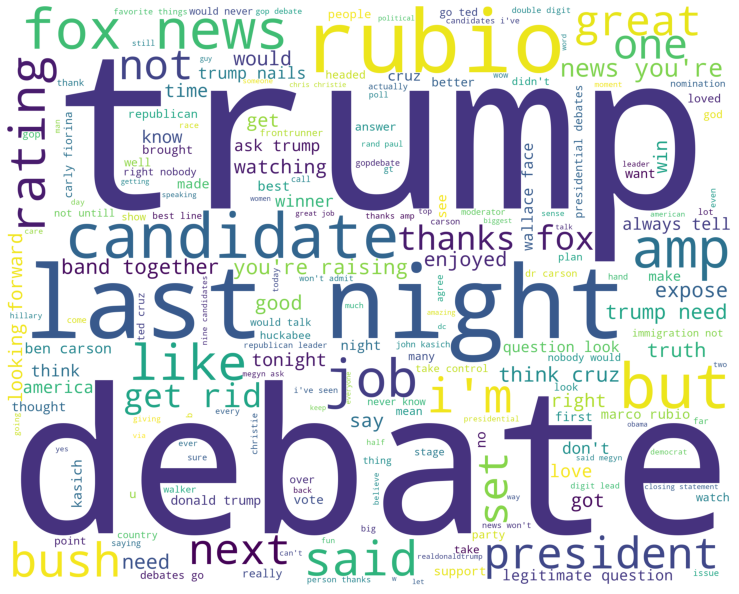

Negative words


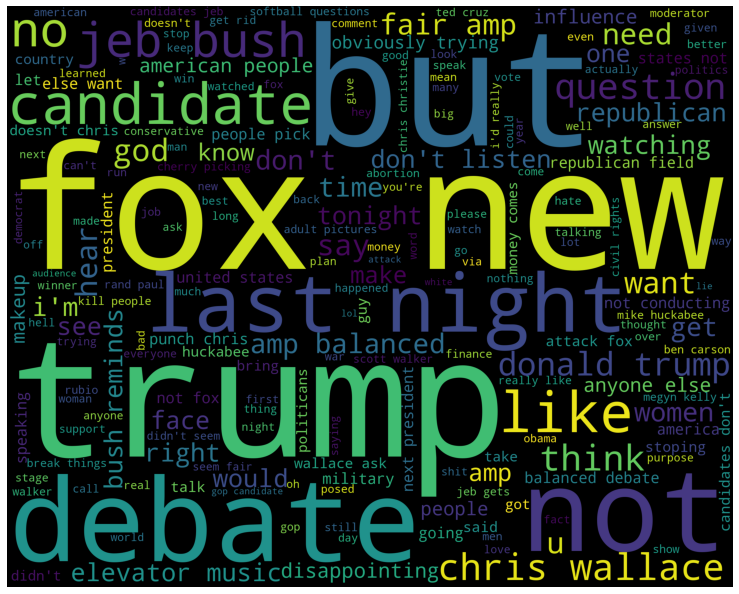

In [43]:
train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['text']

# function to draw wordclouds
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'rt'
                            ])
    wordcloud = WordCloud(stopwords=stopwordlist,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

# Model training

In [44]:
# function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [54]:
# splitting the data into train & test sets
X_train,X_test,y_train,y_test = train_test_split(df['text'], df.sentiment, test_size=0.2, random_state=42)

Logistic Regression

In [55]:
# vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('model', LogisticRegression())])
# fitting the model
model = pipe.fit(X_train, y_train)
# accuracy
prediction = model.predict(X_test)
print("accuracy (logistic regression): {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy (logistic regression): 85.55%


Text(0.5, 15.0, 'Predicted')

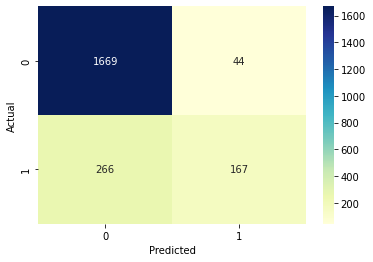

In [48]:
conf_matrix = confusion_matrix(y_test, prediction)
axes = plt.subplot
sns.heatmap(conf_matrix, annot = True, cmap = 'YlGnBu', fmt = 'g')
plt.ylabel('Actual')
plt.xlabel('Predicted')

Decision tree classifier



In [56]:
from sklearn.tree import DecisionTreeClassifier

# vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# fitting the model
model = pipe.fit(X_train, y_train)
# accuracy
prediction = model.predict(X_test)
print("accuracy (decision tree): {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy (decision tree): 84.06%


Text(0.5, 15.0, 'Predicted')

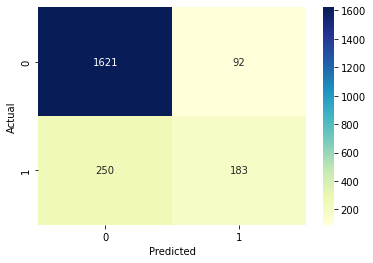

In [50]:
conf_matrix = confusion_matrix(y_test, prediction)
axes = plt.subplot
sns.heatmap(conf_matrix, annot = True, cmap = 'YlGnBu', fmt = 'g')
plt.ylabel('Actual')
plt.xlabel('Predicted')

Random forest

In [57]:
from sklearn.ensemble import RandomForestClassifier

# vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])
# fitting the model
model = pipe.fit(X_train, y_train)
# accuracy
prediction = model.predict(X_test)
print("accuracy (random forest): {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy (random forest): 85.51%


Text(0.5, 15.0, 'Predicted')

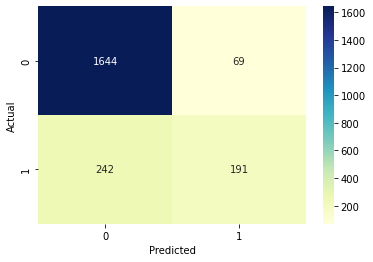

In [58]:
conf_matrix = confusion_matrix(y_test, prediction)
axes = plt.subplot
sns.heatmap(conf_matrix, annot = True, cmap = 'YlGnBu', fmt = 'g')
plt.ylabel('Actual')
plt.xlabel('Predicted')